In [118]:
import csv
import thesis_tools
import numpy as np
import pandas as pd
from astropy.io import fits
import astropy.units as u

import matplotlib.pyplot as plt
plt.style.use('sm')
import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
red=sb.xkcd_palette(['pale red'])[0]

top_path='/Users/codydirks/PGCC/'

def load_results(filename):
    gaia_filenames=[top_path+'tgas_data/TgasSource_000-000-0'+'{:02}'.format(i)+'.fits' for i in range(16)]
    pgcc_hdu=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')
    pgcc_data=pgcc_hdu[1].data
    sightline_pgcc_gaia_data=[]
    with open(filename,'r') as myfile:
        for line in myfile:
            dat=line.strip('|\n').split('|')
            sightline=dat[0]
            coords=dat[1].split(' ')
            ra=float(coords[0])*u.degree
            dec=float(coords[1])*u.degree
            pgcc=pgcc_data[int(dat[2])]
            if dat[3] != 'None':
                fl,idx=map(int,dat[3][1:-1].split(','))
                gfile=fits.open(gaia_filenames[fl])
                gaia_entry=gfile[1].data[idx]
                gfile.close()
            else:
                gaia_entry=None
                
            sightline_pgcc_gaia_data.append([sightline,(ra,dec),pgcc,gaia_entry])
    pgcc_hdu.close()
    return sightline_pgcc_gaia_data


filename='sightline_pgcc_gaia_results.txt'
sightline_pgcc_data=load_results(filename)

sheffer_data=pd.read_csv('sheffer_co_h2.csv')
burgh_data=pd.read_csv('burgh_data.csv')
published_hs=pd.read_csv('clean_vizier_results.csv')

with open('primary_sightlines.csv','r') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=next(inp)
primary_sightlines.remove('HD148937')
sl_data=thesis_tools.load_data(primary_sightlines)
all_data=thesis_tools.load_results(sl_data)

/Users/codydirks/python/thesis_tools/loaders.py:110: RuntimeWarning: divide by zero encountered in log10
  n_dict[ion]=round(np.log10(n_tot),3)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarni

In [ ]:
def hist_plotter(subplt,data,num_bin,xlog=True,ylog=False,col='k'):
    mini,maxi=[min(data),max(data)]
    if xlog:
        mini,maxi=np.log10([mini,maxi])
    bin_lims = np.linspace(mini,maxi,num_bin+1)
    if xlog:
        bin_lims=10**bin_lims
    bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
    bin_widths = bin_lims[1:]-bin_lims[:-1]
    hist, _ = np.histogram(data, bins=bin_lims)
    subplt.bar(bin_centers, hist, width = bin_widths, align = 'center',
               color=col,alpha=0.1,zorder=-1)
    #Trickery to make sure step lines extend to the edges of the histogram bars
    x=np.concatenate([np.array([0.99*bin_lims[0]]),bin_lims])
    y=np.concatenate([np.array([0]),hist,np.array([0])])
    subplt.step(x, y, where='post',
               color=col,alpha=1,zorder=-1)
    if xlog:
        subplt.set_xscale('log')
    if ylog:
        subplt.set_yscale('log')

In [ ]:
fig=plt.figure(1,figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)

uv_h2s=[]
for sl,data in all_data.groupby('Sightline'):
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())

    co_sum=np.log10((10**data['CO']).sum())
    
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0:
        h2_sum=np.log10(published_h2s.iloc[-1])
    else:
        co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
        h2_sum=co_sum-co_h2_ratio
    uv_h2s.append(h2_sum)
    
uv_h2s=np.log10(np.array([i[2]['NH2'] for i in sightline_pgcc_data if i[0] in primary_sightlines and i[2]['NH2']>0]))

uv_h2s=10**(np.array(uv_h2s))
pgcc_hdu=fits.open('/Users/codydirks/PGCC/HFI_PCCS_GCC_R2.02.fits')
pgcc_data=pgcc_hdu[1].data
pgcc_hdu.close()
cleaned_data=np.log10(pgcc_data[np.where(pgcc_data['NH2']>0)]['NH2'])
yuan_data=pd.read_csv('/Users/codydirks/Downloads/yuan.csv')
yuan_h2=1e21*yuan_data['NH2']

num_bin = 20
bin_lims = 10**(np.linspace(min(cleaned_data),max(cleaned_data),num_bin+1))
bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
bin_widths = bin_lims[1:]-bin_lims[:-1]
hist2, _ = np.histogram(10**(cleaned_data), bins=bin_lims)
hist2=hist2/10
#hist2b = hist2/np.max(hist2)
subplt.bar(bin_centers, hist2, width = bin_widths, align = 'center',
           color='k',alpha=0.1,zorder=-1)
subplt.step(bin_centers/1.05, hist2, where='mid',
           color='k',alpha=1,zorder=-1,label='All PGCC $\\div$10')
    
##computing the bin properties
num_bin = 20
bin_lims = 10**(np.linspace(min(cleaned_data),max(cleaned_data),num_bin+1))
bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
bin_widths = bin_lims[1:]-bin_lims[:-1]
#Compute histogram
hist1, _ = np.histogram(uv_h2s, bins=bin_lims)
hist1=hist1*10
# Normalize
#hist1b = hist1/np.max(hist1)
subplt.bar(bin_centers, hist1, width = bin_widths, align = 'center',
           color=blue,alpha=0.3,zorder=2)
subplt.step(bin_centers/1.05, hist1, where='mid',
           color=blue,alpha=1,zorder=2,label='This Work $\\times$10')

num_bin = 20
bin_lims = 10**(np.linspace(min(cleaned_data),max(cleaned_data),num_bin+1))
bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
bin_widths = bin_lims[1:]-bin_lims[:-1]
hist3, _ = np.histogram(yuan_h2[np.isfinite(yuan_h2)], bins=bin_lims)
#hist3b = hist3/np.max(hist3)
subplt.bar(bin_centers, hist3, width = bin_widths, align = 'center',
           color=red,alpha=0.3,zorder=1)
subplt.step(bin_centers/1.05, hist3, where='mid',
           color=red,alpha=1,zorder=1,label='Yuan et al. 2016')

leg=plt.legend(fontsize=30,markerscale=20)
for line in leg.get_lines():
    line.set_linewidth(10)
subplt.set_xscale('log')
subplt.set_ylabel('Count',fontsize=30)
subplt.set_xlabel('N(H$_2$)',fontsize=30,labelpad=20)
#subplt.set_yscale('log')

HD23478
HD4768
HD23180
HD185418
HD13841
HD25443
HD208947
HD72350
HD124314
HD43582
HD208440
HD108002
HD220058
HD232522
HD165918
HD112999
HD148594


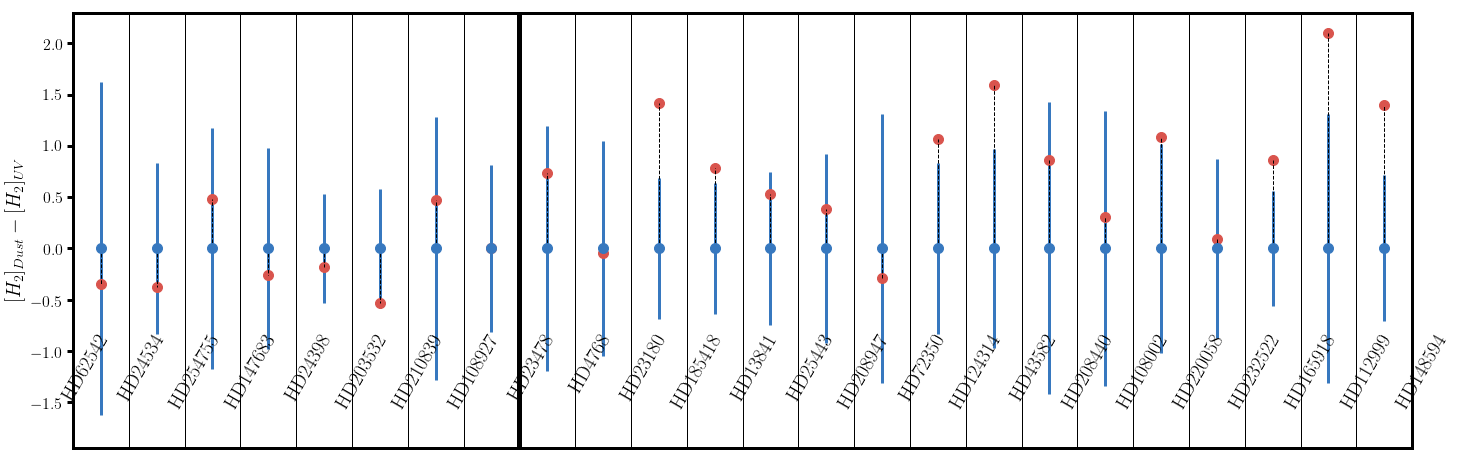

In [133]:
fig=plt.figure(1,figsize=(24,8),facecolor='w')
subplt=plt.subplot(111)
subplt.set_xticklabels([])
subplt.set_xticks([])
h2s=[]
for sl,data in all_data.groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    pgcc=[j[2] for j in sightline_pgcc_data if j[0] == sl][0]
    published_h2s=published_hs[published_hs['Name']==sl][['N(H2)','E_N(H2)']]
    
    component=True
    if component:
        c_sum=np.log10((10**row[['C','C*','C**']]).sum())
        co_sum=row['CO']
        prev_pub_check=len(published_h2s)>0 and len(data)==1
    else:
        c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
        co_sum=np.log10((10**data['CO']).sum())
        prev_pub_check=len(published_h2s)>0
        
    
    if prev_pub_check:
        h2_sum,err=np.log10(published_h2s.iloc[-1])
    else:
        co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
        h2_sum=co_sum-co_h2_ratio
        err=calc_h2_err(row)
    h2s.append((sl,data['R_dist'].iloc[0],co_sum,h2_sum,err,np.log10(pgcc['NH2']),np.log10(pgcc['NH2_sig'])))
h2s.sort(key=lambda x: x[2],reverse=True)

brights,darks=[],[]
for i in range(len(h2s)):
    sl,r,co,uv,uv_err,pgcc,pgcc_err=h2s[i]
    row=all_data[all_data['Sightline']==sl].sort_values('CO',ascending=False).iloc[0]
    tot_err=np.sqrt(0.434*(10**(uv_err-uv)*10**(pgcc_err-pgcc)))
    ms=10
    if row['CO']>15:
        ms=10
        brights.append(abs(uv-pgcc)/tot_err)
    else:
        print(sl)
        darks.append(abs(uv-pgcc)/tot_err)
    subplt.errorbar(i,0,yerr=3*(tot_err),marker='o',color=blue,markersize=ms)
    subplt.plot(i,pgcc-uv,marker='o',color=red,ms=ms)
    subplt.plot([i,i],[0,pgcc-uv],'k--',linewidth=1)
    subplt.axvline(i+0.5,0,1,linestyle='-',linewidth=1)
    subplt.text(i+0.2,-0.8,sl,rotation=60,va='top',ha='right',fontsize=20)

#subplt.text(14.5,2.3,'UV Estimate greater $\\rightarrow$',ha='left',va='bottom',fontsize=25)
#subplt.text(13.5,2.3,'$\\leftarrow$ Dust Estimate greater',ha='right',va='bottom',fontsize=25)
subplt.set_xlim(-0.5,len(h2s)-1.5)
subplt.set_ylabel('$[H_{2}]_{Dust}-[H_{2}]_{UV}$')
#subplt.fill_between([0,25],-0.35,0.35,color='gray',alpha=0.2)

subplt.axvline(7.5,linestyle='-',color='k',linewidth=5)

In [ ]:
fig=plt.figure(1,figsize=(16,16),facecolor='w')
subplt1=plt.subplot(211)
subplt2=subplt1.twinx()
subplt3=plt.subplot(212)
subplt4=subplt3.twinx()
plt.subplots_adjust(hspace=0.35)


uv_cos=[]
uv_rats=[]
for sl,data in all_data.groupby('Sightline'):
    co_sum=np.log10((10**data['CO']).sum())
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0:
        h2_sum=np.log10(published_h2s.iloc[-1])
    else:
        co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
        h2_sum=co_sum-co_h2_ratio
    uv_rats.append(co_sum-h2_sum)
    uv_cos.append(10**co_sum)
uv_cos=np.array(uv_cos)
    
hist_plotter(subplt1,uv_cos,10,col=red)
subplt1.set_ylim(0,6)
subplt1.set_yticklabels(['\\textbf{{{:d}}}'.format(int(i)) for i in subplt1.get_yticks()])
subplt1.tick_params(axis='y', which='major', labelcolor=red,labelsize=25,direction='in',pad=7)


hist_plotter(subplt3,uv_rats,10,xlog=False,col=red)
subplt3.set_ylim(0,10)
subplt3.set_yticklabels(['\\textbf{{{:d}}}'.format(int(i)) for i in subplt3.get_yticks()])
subplt3.tick_params(axis='y', which='major', labelcolor=red,labelsize=25,direction='in',pad=7)



cos=[]
rats=[]
for idx,row in yuan_data[np.isfinite(yuan_data['N13CO'])].iterrows():
    co=1e15*row['N13CO']*(4.7*row['RGal']+25.05)
    rats.append(np.log10(co/(1e21*row['NH2'])))
    cos.append(co)
hist_plotter(subplt2,cos,10,xlog=True,col=blue)
subplt2.set_ylim(0,60)
subplt2.set_yticklabels(['\\textbf{{{:d}}}'.format(int(i)) for i in subplt2.get_yticks()])
subplt2.tick_params(axis='y', which='major', labelcolor=blue,labelsize=25,direction='in',pad=7)


hist_plotter(subplt4,rats,10,xlog=False,col=blue)
subplt4.set_ylim(0,100)
subplt4.set_yticklabels(['\\textbf{{{:d}}}'.format(int(i)) for i in subplt4.get_yticks()])
subplt4.tick_params(axis='y', which='major', labelcolor=blue,labelsize=25,direction='in',pad=7)


subplt1.set_xscale('log')
subplt2.set_xscale('log')
subplt1.tick_params(axis='x',which='major',labelsize=25)
subplt3.tick_params(axis='x',which='major',labelsize=25)
subplt1.set_xlabel('N(CO)',fontsize=30,labelpad=10)
subplt3.set_xlabel('Log CO/H$_2$ Ratio',fontsize=30,labelpad=10)
subplt1.set_ylabel('Count',fontsize=30)
subplt3.set_ylabel('Count',fontsize=30)
#subplt1.set_yscale('log')
#subplt2.set_yscale('log')

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('sm')
import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
red=sb.xkcd_palette(['pale red'])[0]

fig,(subplt1,subplt2,subplt3)=plt.subplots(ncols=1,nrows=3,sharex=True,figsize=(16,12),facecolor='w')
plt.subplots_adjust(hspace=0.1)

co_thres=1e15
    
for sl,data in all_data.groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    co=row['CO']
    co_err=row['CO_err']
    c_sum=np.log10((10**row[['C','C*','C**']]).sum())
    c_sum_err=np.log10(np.sqrt(((10**row[['C_err','C*_err','C**_err']])**2).sum()))
    
    f1=10**(row['C*']-c_sum)
    f2=10**(row['C**']-c_sum)
    f1_err=f1*np.sqrt((10**(row['C*_err']-row['C*']))**2+(10**(c_sum_err-c_sum))**2)
    f2_err=f2*np.sqrt((10**(row['C**_err']-row['C**']))**2+(10**(c_sum_err-c_sum))**2)
    
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0 and len(data)==1:
        h2=np.log10(published_h2s.iloc[-1])
        co_h2_ratio=row['CO']-h2
    else:
        co_h2_ratio=((row['CO']-c_sum)-5.4674)/0.949756
        h2=row['CO']-co_h2_ratio
    fh2=2*(10**h2)/(10**row['H_tot'])
    neutral_c_ratio=(10**(row['CO'])+(10**c_sum))/10**(row['H_tot'])
    co_c_ratio=10**(row['CO']-c_sum)

    col=red
    if row['CO']>np.log10(co_thres):
        col=blue
    subplt1.errorbar(row['R_dist'],10**co,yerr=3*10**co_err,marker='o',color=col,markersize=10)
    
    co_c_ratio_err=co_c_ratio*np.sqrt((10**(row['CO_err']-row['CO']))**2+(10**(c_sum_err-c_sum))**2)
    subplt2.errorbar(row['R_dist'],co_h2_ratio,yerr=f1_err,marker='o',color=col,markersize=10)


In [ ]:
fig,(subplt1,subplt2,subplt3,subplt4)=plt.subplots(ncols=1,nrows=4,sharex=True,figsize=(16,16),facecolor='w')
plt.subplots_adjust(hspace=0.1,top=0.95)

co_thres=1e15
for sl,data in all_data.groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
    co_sum=np.log10((10**data['CO']).sum())
    h_tot=np.log10((10**data['H_tot']).sum())
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0:
        h2_sum=np.log10(published_h2s.iloc[-1])
        co_h2_ratio=co_sum-h2_sum
    else:
        co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
        h2_sum=co_sum-co_h2_ratio
    fh2=2*(10**h2_sum)/(10**h_tot)
    neutral_c_ratio=(10**(co_sum)+(10**c_sum))/10**(h_tot)
    co_c_ratio=10**(co_sum-c_sum)
        
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=calc_f(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
    f=np.mean(f_vals)
    f_err=np.sqrt(np.sum(f_errs**2))
    col=red
    if co_c_ratio>1 and co_h2_ratio>-6:
        col=blue
    subplt1.plot(row['R_dist'],10**(co_sum),marker='o',color=col,markersize=20)
    subplt2.plot(row['R_dist'],10**(c_sum),marker='o',color=col,markersize=20)
    subplt3.plot(row['R_dist'],co_c_ratio,marker='o',color=col,markersize=20)
    subplt4.plot(row['R_dist'],fh2,marker='o',color=col,markersize=20)
    
fig.suptitle("Sightline-Integrated",fontsize=35)
subplt4.set_xlim(0,10)
#subplt1.set_ylim(8e14,5e16)
#subplt2.set_ylim(8e-7,3e-5)
#subplt3.set_ylim(2,12)
#subplt4.set_ylim(0.000005,0.0001)
subplt1.set_yscale('log')
subplt2.set_yscale('log')
#subplt4.set_yscale('log')
#subplt3.set_yscale('log')
#subplt4.set_yscale('log')
#subplt3.set_yscale('log')
#subplt4.set_yscale('log')

subplt4.set_xlabel('Distance ($\sigma$)')
subplt1.set_ylabel('N(CO)')
subplt2.set_ylabel('N(C I)')
subplt3.set_ylabel('CO/C')
subplt4.set_ylabel('f$_{H_2}$')

#subplt1.axhline(co_thres,linestyle='--',color='r')
subplt3.axhline(1,linestyle='--',color='r')
#plt.savefig('/Users/codydirks/Desktop/4.pdf')

In [ ]:
# Do my single-component sightlines meet Burgh's criteria for translucence?
#   - All of the sightline-integrated "translucent" sightlines are also translucent 
# as single components, plus extras

# Focus on extremes of NH2 distribution

# Emphasize that I'm not focusing on sightlines - but rather focusing on specific clouds using components

# Make list of interesting points to include in paper

In [ ]:
import seaborn as sb

fig,(subplt1,subplt2,subplt3)=plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(16,16),facecolor='w')
plt.subplots_adjust(wspace=0)
#subplt=plt.subplot(111)

pgcc_h2s=[]
sl_h2s=[]
comp_h2s=[]
for sl, data in all_data[all_data['R_dist']<20].groupby('Sightline'):
    pgcc=[i[2] for i in sightline_pgcc_data if i[0]==sl][0]
    r=data.iloc[0]['R_dist']
    subplt1.plot(r,pgcc['NH2'],'ko',markersize=20)
    print(sl,pgcc['Name'],pgcc['NH2'],r)
    pgcc_h2s.append(pgcc['NH2'])
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
    co_sum=np.log10((10**data['CO']).sum())
    co_c_ratio=co_sum-c_sum
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0:
        h2=np.log10(published_h2s.iloc[-1])
        co_h2_ratio=co_sum-h2
    else:
        co_h2_ratio=((co_c_ratio)-5.4674)/0.949756
        h2=co_sum-co_h2_ratio
    subplt2.plot(r,10**h2,marker='o',color=red,markersize=20)
    sl_h2s.append(10**h2)
    
    row=data.sort_values('CO',ascending=False).iloc[0]
    c_sum=np.log10((10**row[['C','C*','C**']]).sum())
    co_sum=row['CO']
    co_c_ratio=co_sum-c_sum
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0 and len(data)==1:
        h2=np.log10(published_h2s.iloc[-1])
        co_h2_ratio=co_sum-h2
    else:
        co_h2_ratio=((co_c_ratio)-5.4674)/0.949756
        h2=co_sum-co_h2_ratio
    subplt3.plot(r,10**h2,marker='o',color=blue,markersize=20)
    comp_h2s.append(10**h2)
    
pgcc_h2s=np.array(pgcc_h2s)
sl_h2s=np.array(sl_h2s)
comp_h2s=np.array(comp_h2s)
pgcc_h2s=pgcc_h2s[np.where(pgcc_h2s>0)]
#sb.kdeplot(np.log10(pgcc_h2s),bw=0.6,ax=subplt,shade=True,color='k',alpha=0.4)
#sb.kdeplot(np.log10(sl_h2s),ax=subplt,shade=True,color=red,alpha=0.4)
#sb.kdeplot(np.log10(comp_h2s),ax=subplt,shade=True,color=blue,alpha=0.4)
num_cut=4
pgcc_h2s=np.sort(pgcc_h2s)
sl_h2s=np.sort(sl_h2s)
comp_h2s=np.sort(comp_h2s)
#subplt1.axhline(pgcc_h2s[num_cut-1],linestyle='--',color='k',linewidth=1)
#subplt1.axhline(pgcc_h2s[-num_cut],linestyle='--',color='k',linewidth=1)
subplt1.fill_between([0,11],pgcc_h2s[0],pgcc_h2s[num_cut-1],color='k',alpha=0.2)
pgcc_min=pgcc_h2s[num_cut-1]
subplt1.fill_between([0,11],pgcc_h2s[-num_cut],pgcc_h2s[-1],color='k',alpha=0.2)
pgcc_max=pgcc_h2s[-num_cut]

subplt2.fill_between([0,11],sl_h2s[0],sl_h2s[num_cut-1],color=red,alpha=0.2)
sl_min=sl_h2s[num_cut-1]
subplt2.fill_between([0,11],sl_h2s[-num_cut],sl_h2s[-1],color=red,alpha=0.2)
sl_max=sl_h2s[-num_cut]

subplt3.fill_between([0,11],comp_h2s[0],comp_h2s[num_cut-1],color=blue,alpha=0.2)
comp_min=comp_h2s[num_cut-1]
subplt3.fill_between([0,11],comp_h2s[-num_cut],comp_h2s[-1],color=blue,alpha=0.2)
comp_max=comp_h2s[-num_cut]

subplt1.set_yscale('log')
subplt1.set_xlim(0,11)
subplt2.set_yscale('log')
subplt2.set_xlim(0,11)
subplt3.set_yscale('log')
subplt3.set_xlim(0,11)

subplt1.set_title('PGCC',fontsize=30)
subplt2.set_title('Sightline',fontsize=30)
subplt3.set_title('Component',fontsize=30)
subplt1.set_ylabel('N(H$_2$)',fontsize=30)
subplt2.set_xlabel('Distance',fontsize=40)

In [ ]:
pgcc_lows,pgcc_highs=[],[]
sl_lows,sl_highs=[],[]
comp_lows,comp_highs=[],[]

param='CO/C'
for sl, data in all_data[all_data['R_dist']<20].groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    c_sum=np.log10((10**row[['C','C*','C**']]).sum())
    co_sum=row['CO']
    if param=='CO':
        value=co_sum
    elif param=='CO/C':
        value=co_sum-c_sum
    
    r=row['R_dist']
    
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
    co_sum=np.log10((10**data['CO']).sum())
    co_c_ratio=co_sum-c_sum
    pgcc=[i[2] for i in sightline_pgcc_data if i[0]==sl][0]
    if pgcc['NH2']>=pgcc_max:
        pgcc_highs.append((r,10**value))
    elif pgcc['NH2']<=pgcc_min:
        pgcc_lows.append((r,10**value))
    
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0:
        h2=np.log10(published_h2s.iloc[-1])
        co_h2_ratio=co_sum-h2
    else:
        co_h2_ratio=((co_c_ratio)-5.4674)/0.949756
        h2=co_sum-co_h2_ratio
    if 10**h2>=sl_max:
        sl_highs.append((r,10**value))
    elif 10**h2<=sl_min:
        sl_lows.append((r,10**value))
    
    c_sum=np.log10((10**row[['C','C*','C**']]).sum())
    co_sum=row['CO']
    co_c_ratio=co_sum-c_sum
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0 and len(data)==1:
        h2=np.log10(published_h2s.iloc[-1])
        co_h2_ratio=co_sum-h2
    else:
        co_h2_ratio=((co_c_ratio)-5.4674)/0.949756
        h2=co_sum-co_h2_ratio
    if 10**h2>=comp_max:
        comp_highs.append((r,10**value))
    elif 10**h2<=comp_min:
        comp_lows.append((r,10**value))

print(len(pgcc_lows),len(pgcc_highs),len(sl_lows),len(sl_highs),len(comp_lows),len(comp_highs))

fig,(subplt1,subplt2,subplt3)=plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(16,6),facecolor='w')
plt.subplots_adjust(wspace=0)

subplt1.scatter(*zip(*pgcc_highs),marker='o',color=blue,s=200)
subplt1.scatter(*zip(*pgcc_lows),marker='o',color=red,s=200)

subplt2.scatter(*zip(*sl_highs),marker='o',color=blue,s=200)
subplt2.scatter(*zip(*sl_lows),marker='o',color=red,s=200)

subplt3.scatter(*zip(*comp_highs),marker='o',color=blue,s=200,label=str(num_cut)+' Highest N(H$_2$)')
subplt3.scatter(*zip(*comp_lows),marker='o',color=red,s=200,label=str(num_cut)+' Lowest N(H$_2$)')

subplt1.set_xlim(0,11)
subplt2.set_xlim(0,11)
subplt3.set_xlim(0,11)

subplt3.legend(fontsize=15,scatteryoffsets=[0.75],handletextpad=0)
subplt1.set_ylabel(param,fontsize=30)
subplt2.set_xlabel('Distance',labelpad=20,fontsize=30)
subplt1.set_title('PGCC N(H$_2$)',fontsize=20)
subplt2.set_title('Sightline N(H$_2$)',fontsize=20)
subplt3.set_title('Component N(H$_2$)',fontsize=20)

if param=='CO':
    subplt1.set_yscale('log')
    subplt1.set_ylim(1e12,1e17);

In [ ]:
bright=0.
dark=0.
for sl, data in all_data.groupby('Sightline'):
    co_sum=(10**data['CO']).sum()
    if co_sum>1e15:
        bright=bright+co_sum
    else:
        dark=dark+co_sum
sm=bright+dark
print(bright/sm,dark/sm)

In [ ]:
from astropy.coordinates import SkyCoord,UnitSphericalRepresentation
import astropy.units as u
# Returns the velocity shift necessary to convert Helio to LSR
# i.e. returns (V_lsr - V_helio) in km/s
def HelioToLSR(target_ra_deg, target_dec_deg):
    # Defines Solar motion: 19.7 km/s toward 18h,+30d
    Vsun=19.7
    a0=271.0
    d0=30.0
    
    coord=SkyCoord(ra=target_ra_deg*u.degree,dec=target_dec_deg*u.degree)
    direction=SkyCoord(a0*u.degree,d0*u.degree,frame='fk5',equinox='J1900')
    uvw_lsr=direction.galactic.cartesian.xyz*19.7*u.km/u.s
    unit=coord.galactic.represent_as(UnitSphericalRepresentation)
    cartesian=unit.to_cartesian()
    lsr_vector=(cartesian.xyz.T*uvw_lsr).T
    return np.sum(lsr_vector).value

print(HelioToLSR(350.079,+55.808)+87.91)

In [ ]:
def HelioToLSR(target_ra_deg, target_dec_deg):
    Vsun=19.7
    a0=271.0*np.pi/180.
    d0=30.0*np.pi/180.
    a=target_ra_deg*np.pi/180.
    d=target_dec_deg*np.pi/180.
    #shift=Vsun*(np.cos(a-a0)*np.cos(a0)*np.cos(a)+np.sin(d0)*np.sin(d))
    shift=Vsun*(np.cos(a0)*np.cos(d0)*np.cos(a)*np.cos(d)
                +np.sin(a0)*np.cos(d0)*np.sin(a)*np.cos(d)
                +np.sin(d0)*np.sin(d))
    return shift
print(HelioToLSR(350.0792285119258,+55.8077983493516))

In [ ]:
from astropy.coordinates import SkyCoord,UnitSphericalRepresentation

s=SkyCoord(ra=350.079*u.degree,dec=55.808*u.degree)

def vhelio_to_vlsr(coord, vhelio=0*u.km/u.s, lsr_definition='dynamical'):
    """
    Convert heliocentric radial velocity to Local Standard of Rest radial velocity
    Parameters
    ----------
    coord : SkyCoord
        The direction at which to compute the conversion factor.
    vhelio : Quantity with velocity units
        The heliocentric radial velocity.  Should be a scalar quantity or match the shape of `coord`.
    lsr_definition : str or Quantity with velocity units
        The definition of LSR to assume.  This can be one of three options:
        * 'kinematic' : 20 km/s towards 18h,+30 deg (at 1900)
        * 'dynamical' : IAU definition of (9, 12, 7) km/sec in Galactic cartesian coordinates
        * A length-3 vector with the U, V, and W components (velocity along the galactic x, y, and z axes)
          to assume for the LSR.
    Returns
    -------
    vlsr : Quantity
        The velocity in the Local Standard of Rest frame.
    """
    if lsr_definition == 'kinematic':
        direction = SkyCoord('18h', '30d', frame='fk5', equinox='J1900')
        velocity = 19.7*u.km/u.s
        uvw_lsr = direction.galactic.cartesian.xyz * velocity
    elif lsr_definition == 'dynamical':
        uvw_lsr = (9, 12, 7)*u.km/u.s
    else:
        uvw_lsr = lsr_definition

    # the unitspherical conversion ensures that the resulting cartesian is a *unit* vector
    usr = coord.galactic.represent_as(UnitSphericalRepresentation)
    cart = usr.to_cartesian()
    vlsr_vector = (cart.xyz.T*uvw_lsr).T

    return vhelio + np.sum(vlsr_vector)


print(vhelio_to_vlsr(s,vhelio=87.91*u.km/u.s,lsr_definition='kinematic'))

In [14]:
def calc_h2_err(row,co=None,co_err=None,c=None,c_err=None,h2=None):
    # Calculates the error in the H2 column density
    # as determined using the CO/C and CO/H2 ratios
    a=1/(0.949756**2)-1
    if not co:
        co=row['CO']
    if not co_err:
        co_err=row['CO_err']
    co_frac_err=10**(co_err-co)
    
    if not c:
        c=np.log10((10**row[['C','C*','C**']]).sum())
    if not c_err:
        c_err=np.log10(np.sqrt(((10**row[['C_err','C*_err','C**_err']])**2).sum()))
    c_frac_err=10**(c_err-c)
    
    if not h2:
        co_h2_ratio=((co-c)-5.4674)/0.949756
        h2=co_sum-co_h2_ratio
        
        
    h2_frac_err=np.sqrt((a*(co_frac_err**2))+c_frac_err**2)
    h2_err=np.log10(h2_frac_err)+h2
    return h2_err

In [ ]:
import matplotlib as mpl
fig=plt.figure(figsize=(24,8),facecolor='w')
subplt=plt.subplot(111)
subplt.set_yscale('log')
subplt.set_xticks(np.arange(0.5,25,1))
subplt.set_xticklabels([])
subplt.set_xlim(-0.5,24.5)
subplt.set_ylim(1e19,4e22)
i=0
for r_dist,data in sorted_data.groupby('R_dist'):
    sl=data.iloc[0]['Sightline']
    pgcc=[j[2] for j in sightline_pgcc_data if j[0] == sl][0]
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
    c_sum_err=np.log10(np.sqrt(((10**data[['C_err','C*_err','C**_err']])**2).sum().sum()))
    if c_sum_err>c_sum:
        c_sum_err=c_sum

    co_sum=np.log10((10**data['CO']).sum())
    co_sum_err=np.log10(np.sqrt(((10**data['CO_err'])**2).sum()))
    
    published_h2s=published_hs[published_hs['Name']==sl][['N(H2)','E_N(H2)']]
    if len(published_h2s)>0:
        h2_sum,h2_sum_err=np.log10(published_h2s.iloc[-1])
    else:
        co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
        h2_sum=co_sum-co_h2_ratio
        h2_sum_err=np.nan
    if np.isnan(h2_sum_err):
        h2_sum_err=calc_h2_err([],co=co_sum,co_err=co_sum_err,c=c_sum,c_err=c_sum_err,h2=h2_sum)
    
    if r_dist<10:
        subplt.errorbar(i-0.2,10**h2_sum,yerr=10**h2_sum_err,color=blue,alpha=1.0,elinewidth=5,marker='o',markersize=15)
        subplt.errorbar(i+0.2,pgcc['NH2'],yerr=pgcc['NH2_sig'],color='k',alpha=1.0,elinewidth=5,marker='o',markersize=15)
        subplt.axvline(i+0.5,linestyle='-',color='k',linewidth=1)
        subplt.text(i+0.3,8e18,sl,rotation=60,va='top',ha='right',fontsize=25)
        col='g'
        if (10**h2_sum-10**h2_sum_err)>(pgcc['NH2']+pgcc['NH2_sig']) or (10**h2_sum+10**h2_sum_err)<(pgcc['NH2']-pgcc['NH2_sig']):
            col=red
        subplt.fill_between([i-0.5,i+0.5],1e18,4e22,color=col,alpha=0.1)
        i=i+1
subplt.set_ylabel('N(H$_2$)')

patches = [mpl.lines.Line2D([],[],color=col, label=text,linestyle='-',linewidth=5,marker='o',markersize=15) 
           for col,text in ((blue,'UV Absorption'),('k','Planck (Dust)'))]
leg=plt.legend(handles=patches,ncol=len(patches),loc='lower right',bbox_to_anchor=(1,1),fontsize=30,handlelength=1)

subplt.axvline(6.5,linestyle='-',color='k',linewidth=3)

In [ ]:
# Compiles the Jenkins f1,f2 data
jenkins_c_data=pd.read_csv('jenkins_c_table.txt',header=23)
jenkins_c_data['C*']=np.log10(jenkins_c_data['f1']*jenkins_c_data['N(CIt)'])
jenkins_c_data['C**']=np.log10(jenkins_c_data['f2']*jenkins_c_data['N(CIt)'])
jenkins_c_data['C']=np.log10(jenkins_c_data['N(CIt)']-(10**jenkins_c_data['C*']+10**jenkins_c_data['C**']))
jenkins_c_data['N(CIt)']=np.log10(jenkins_c_data['N(CIt)'])
jenkins_c_data=jenkins_c_data.rename(index=str, columns={"N(CIt)": "Ctot", "Name": "Sightline", "Vel":"Velocity"})
jenkins_c_data=jenkins_c_data[['Sightline','Velocity','C','C*','C**','Ctot','f1','e_f1','f2','e_f2']]

In [ ]:
fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)

x = jenkins_c_data['f1']
y = jenkins_c_data['f2']
xmin, xmax = -0.02, 0.52
ymin, ymax = -0.02, 0.6

subplt.plot(x,y,'ko',markersize=1,zorder=1,alpha=0.5,label='Jenkins \\& Tripp (2011)')
subplt.set_xlim(xmin,xmax)
subplt.set_ylim(ymin,ymax)

cut_data=all_data[(all_data['C']>0)&(all_data['C*']>0)&(all_data['C**']>0)]
    
brights,bright_errs=[],[]
darks,dark_errs=[],[]
for sl,data in all_data.groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    c_tot=(10.**row[['C','C*','C**']]).sum()
    c_tot_err=np.sqrt(((10.**row[['C_err','C*_err','C**_err']])**2).sum())
    f1=(10**row['C*'])/c_tot
    f2=(10**row['C**'])/c_tot
    f1_err=f1*np.sqrt((10**(row['C*_err']-row['C*']))**2+(c_tot_err/c_tot)**2)
    f2_err=f2*np.sqrt((10**(row['C**_err']-row['C**']))**2+(c_tot_err/c_tot)**2)
    if row['CO']>15:
        brights.append((f1,f2))
        bright_errs.append((f1_err,f2_err))
    else:
        darks.append((f1,f2))
        dark_errs.append((f1_err,f2_err))

x,y=list(zip(*brights))
xerr,yerr=list(zip(*bright_errs))
subplt.errorbar(x,y,xerr=xerr,yerr=yerr,
                color=blue,linestyle='None',marker='o',markersize=15,zorder=3,label='CO -- Bright')

x,y=list(zip(*darks))
xerr,yerr=list(zip(*dark_errs))
subplt.errorbar(x,y,xerr=xerr,yerr=yerr,
                color=red,linestyle='None',marker='o',markersize=15,zorder=2, label='CO -- Dark')

plt.tick_params(axis='both',which='major',labelsize=25)
subplt.set_xlabel('f1',fontsize=30)
subplt.set_ylabel('f2',fontsize=30)

plt.legend(loc=2,fontsize=25)
#plt.savefig()

In [ ]:
fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)
for sl,data in all_data.groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    col=red
    if row['CO']>15:
        col=blue
    pgcc=[i[2] for i in sightline_pgcc_data if i[0]==sl][0]
    nh2=pgcc['NH2']
    err=pgcc['NH2_sig']
    row=data.sort_values('CO',ascending=False).iloc[0]
    if nh2>0:
        yerr=0.434*(err/nh2)
        subplt.errorbar(row['R_dist'],np.log10(nh2),yerr=yerr,marker='o',color=col,markersize=20)
        
for sl,r in [('HD94414',0.7),('HD147196',0.8),('HD217943',1.0),('HD236101',0.7),('HD334041',0.7)]:
    pgcc=[i[2] for i in sightline_pgcc_data if i[0]==sl][0]
    nh2=pgcc['NH2']
    err=pgcc['NH2_sig']
    yerr=0.434*(err/nh2)
    subplt.errorbar(r,np.log10(nh2),yerr=yerr,marker='o',color='k',markersize=20)
subplt.set_xlim(0,10)
subplt.set_xlabel('Distance $\sigma$')
subplt.set_ylabel('Log N(H$_2$)$_{\mathrm{PGCC}}$')

In [ ]:
from PIL import Image
fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)

img=Image.open('/Users/codydirks/Desktop/jenkins.png')
subplt.imshow(img.crop((221,20,1705,1492)),extent=[0,0.55,0,0.55])

    
pts=[(1,0.025,0.003),
    (5,0.043,0.005),
    (1,0.092,0.0135),
    (1.1,0.109,0.016),
    (1.2,0.1285,0.0195),
    (1.3,0.151,0.024),
    (1.4,0.178,0.0295),
    (1.5,0.2075,0.036),
    (1.6,0.24,0.0448),
    (1.7,0.274,0.0547),
    (1.8,0.309,0.0668),
    (1.9,0.3436,0.0815),
    (2.0,0.376,0.0977),
    (2.1,0.4055,0.117),
    (2.2,0.43,0.1384),
    (2.3,0.4492,0.1617),
    (2.4,0.4623,0.1868),
    (2.5,0.47,0.212),
    (2.6,0.473,0.238),
    (2.7,0.4715,0.2635),
    (2.8,0.4673,0.2877),
    (2.9,0.461,0.31),
    (3.0,0.4535,0.3305),
    (3.1,0.4455,0.349),
    (3.2,0.438,0.364),
    (3.3,0.4307,0.378),
    (3.4,0.4245,0.39),
    (3.5,0.419,0.399),
    (3.6,0.414,0.4073),
    (3.7,0.4097,0.414),
    (3.8,0.4065,0.4195),
    (4.0,0.4015,0.4275),
    (5.0,0.393,0.44)]

n,x,y=list(zip(*pts))
subplt.plot(x,y,'ro',linestyle='-',markersize=10)
#subplt.set_xlim(0.4,0.5)
#subplt.set_ylim(0.3,0.4)

In [ ]:
import pickle as pkl
with open('gong_results.pkl','rb') as gong_pickle:
    gong_results=pkl.load(gong_pickle)

In [ ]:
fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)

for sl,data in all_data.groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    subplt.plot(row['H_tot'],row['CO'],'ko')
for n,((sp,(h,c)),(_,(_,co)),(_,(_,cii)),(_,(_,h2))) in gong_results:
    subplt.plot(h,co)
subplt.set_xlim(20,22)

In [ ]:
fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)
for sl, data in all_data.groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    published_h2s=np.log10(published_hs[published_hs['Name']==sl][['N(H2)','E_N(H2)']])
    if len(published_h2s)>0:
        pub_h2,pub_h2_err=published_h2s.iloc[-1]
        if len(data)==1:
            co=row['CO']
            c=np.log10((10**row[['C','C*','C**']]).sum())
            col=blue
        else:
            co=np.log10((10**data['CO']).sum())
            c=np.log10((10**data[['C','C*','C**']]).sum().sum())
            col='k'
        co_h2_ratio=((co-c)-5.4674)/0.949756
        h2=co-co_h2_ratio
        print('{:>4.2f}'.format(abs(pub_h2-h2)))
        subplt.plot(pub_h2,h2,marker='o',color=col)
tx=np.arange(20,21.2,0.1)
subplt.plot(tx,tx,'r--',linewidth=1)
for i in (0.1,0.2,0.3):
    subplt.fill_between(tx,tx-i,tx+i,color='gray',alpha=0.2,zorder=-1)
subplt.set_ylim(20,21.2)
subplt.set_xlim(20,21)

subplt.set_xlabel('Published Value')
subplt.set_ylabel('Calculated Value')

In [ ]:
pgcc_hdu=fits.open('/Users/codydirks/PGCC/HFI_PCCS_GCC_R2.02.fits')
pgcc_data=pgcc_hdu[1].data
pgcc_hdu.close()


In [ ]:
planck_co_hdu=fits.open('/Users/codydirks/PGCC/CO/HFI_CompMap_CO-Type3_2048_R1.10.fits')
planck_co_data=planck_co_hdu[1].data
planck_co_hdu.close()

In [3]:
import healpy as hp
from matplotlib import cm
% matplotlib inline
planck_co_map=hp.read_map('/Users/codydirks/PGCC/CO/HFI_CompMap_CO-Type3_2048_R1.10.fits')

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


Ordering converted to RING


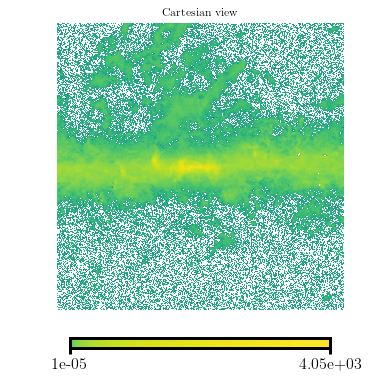

In [12]:
sl='HD62542'
for 
hp.cartview(planck_co_map,latra=[-10,10],lonra=[-10,10],min=0.00001,norm='log',cmap=cm.viridis)

In [103]:
def old_calc_h2_err(row,co=None,co_err=None,c=None,c_err=None,h2=None):
    # Calculates the error in the H2 column density
    # as determined using the CO/C and CO/H2 ratios
    a=1/(0.949756**2)-1
    if not co:
        co=row['CO']
    if not co_err:
        co_err=row['CO_err']
    co_frac_err=10**(co_err-co)
    
    if not c:
        c=np.log10((10**row[['C','C*','C**']]).sum())
    if not c_err:
        c_err=np.log10(np.sqrt(((10**row[['C_err','C*_err','C**_err']])**2).sum()))
    c_frac_err=10**(c_err-c)
    
    if not h2:
        co_h2_ratio=((co-c)-5.4674)/0.949756
        h2=co_sum-co_h2_ratio
        
        
    h2_frac_err=np.sqrt((a*(co_frac_err**2))+c_frac_err**2)
    h2_err=np.log10(h2_frac_err)+h2
    return h2_err

In [104]:
def calc_h2_err(row,co=None,co_err=None,c=None,c_err=None,h2=None):
    m=0.9662
    dm=0.05089
    b=5.5722
    db=0.3079
    
    if not co:
        co=row['CO']
    if not co_err:
        co_err=row['CO_err']
    co_frac_err=10**(co_err-co)
    
    if not c:
        c=np.log10((10**row[['C','C*','C**']]).sum())
    if not c_err:
        c_err=np.log10(np.sqrt(((10**row[['C_err','C*_err','C**_err']])**2).sum()))
    c_frac_err=10**(c_err-c)
    co_c_ratio=co-c
    
    if not h2:
        co_h2_ratio=((co-c)-b)/m
        h2=co_sum-co_h2_ratio
    
    d_co_h2_ratio=(1/m**2)*((0.434*(co_frac_err**2+c_frac_err**2))**2+db**2)+(((b-co_c_ratio)/m**2)**2)*dm**2
    h2_frac_err=(np.sqrt((d_co_h2_ratio/0.434)**2-co_frac_err**2))
    return np.log10(h2_frac_err*(10**h2))

In [153]:
for sl,data in all_data.groupby('Sightline'):
    row=data.sort_values('CO',ascending=False).iloc[0]
    published_h2s=published_hs[published_hs['Name']==sl][['N(H2)','E_N(H2)']]
    
    component=False
    if component:
        c_sum=np.log10((10**row[['C','C*','C**']]).sum())
        co_sum=row['CO']
        prev_pub_check=len(published_h2s)>0 and len(data)==1
    else:
        c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
        co_sum=np.log10((10**data['CO']).sum())
        prev_pub_check=len(published_h2s)>0
        
    
    if prev_pub_check:
        h2_sum,err=np.log10(published_h2s.iloc[-1])
    else:
        co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
        h2_sum=co_sum-co_h2_ratio
    
    print(sl,'{:>4.2f}'.format(2*10**h2_sum/(10**data['H_tot']).sum()))
    
    #print(sl,'{:>4.2f}'.format(h2_sum),'{:>4.2f}'.format(row['H_tot']))#'{:>4.2f}'.format(0.434*10**(calc_h2_err(row)-h2_sum)))

HD108002 0.15
HD108927 0.49
HD112999 0.09
HD124314 0.12
HD13841 0.24
HD147683 0.41
HD148594 0.11
HD165918 0.17
HD185418 0.31
HD203532 0.42
HD208440 0.13
HD208947 0.71
HD210839 0.32
HD220058 0.23
HD23180 0.42
HD232522 0.17
HD23478 0.38
HD24398 0.50
HD24534 0.74
HD25443 0.19
HD254755 0.14
HD43582 0.14
HD4768 0.58
HD62542 0.47
HD72350 1.01


In [136]:
print(brights)
print(np.mean(brights))
print(len(np.where(np.array(brights)>3)[0]),len(brights))

[0.6351743478699033, 1.350447253266617, 1.2356089997472208, 0.7983247880318108, 1.0319516381841896, 2.73527223854272, 1.108424264814078, 0.0010912725076372533]
1.112036850370522
0 8


In [135]:
print(darks)
print(np.mean(darks))
print(len(np.where(np.array(darks)>3)[0]),len(darks))

[1.858224889013123, 0.1212778709759906, 6.208633107245289, 3.701587029036144, 2.1469303165863667, 1.231567956726395, 0.6488328672053577, 3.8112476611779122, 4.932486650335339, 1.814921738748577, 0.6940207718299254, 3.1909023917820862, 0.3050896382259157, 4.604471949790256, 4.821512088153465, 5.908972349573001, 1.49273951391058]
2.793730517077396
8 17
